# ==== INTERACTIVE CLUSTERING : BUSINESS CONSISTENCY STUDY ====
> ### Stage 1 : Initialize computation environments for experiments.

------------------------------
## READ-ME BEFORE RUNNING

### Quick Description

This notebook is **aimed at create environments needed to run business consistency study experiments**.
- Environments are represented by subdirectories in the `/experiments` folder. A full path to an experiment environment is `/experiments/[DATASET]/[CLUSTERING_EVOLUTION]`.
- The path is composed of A. the dataset used and B. the clustering evolution (cf. convergence study results).

At beginning of the comparative study, **run this notebook to set up experiments you want**.

Then, **go to the notebook `2_Compute_terms_analysis_with_FMC.ipynb` to run and evaluate each experiment you have set**.

### Description each steps

- 2.1. **Set up `Dataset` environments**:
    - _Description_: Create a subdirectory, store parameters for the dataset and pre-format dataset for next computations.
    - _Setting_: A dictionary define all possible configurations of datatset environments.
    - _Folder content_:
        - `dict_of_texts.json`: texts from the dataset;
        - `dict_of_true_intents.json`: true intent from the dataset;
        - `fmc_analysis.json`: results of Features Maximization Metric computation;
        - `config.json`: a json file with all parameters.
    - _Available datasets_:
        - [French trainset for chatbots dealing with usual requests on bank cards v1.0.0](http://doi.org/10.5281/zenodo.4769949)

- 2.2. **Set up `Clustering` environments**:
    - _Description_: Create a subdirectory, store parameters, then ... # TODO
    - _Setting_: A dictionary define all possible configurations of preprocessing + vectorization + clustering environments.
    - _Folder content_:
        - `dict_of_clustering_results.json`: clustering results over interactive-clustering iterations;
        - `fmc_analysis.json`: results of Features Maximization Metric computation for each iteration;
        - `config.json`: a json file with all parameters.

------------------------------
## 1. IMPORT PYTHON DEPENDENCIES

In [1]:
import os
import listing_envs
from typing import Any, Dict, List, Optional, Tuple
from scipy.sparse import csr_matrix
import pandas as pd
import json
import pickle  # noqa: S403
from cognitivefactory.interactive_clustering.utils.preprocessing import (
    preprocess,
)
from cognitivefactory.interactive_clustering.utils.vectorization import (
    vectorize,
)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from cognitivefactory.features_maximization_metric.fmc import FeaturesMaximizationMetric
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
import pandas as pd

------------------------------
## 2. CREATE COMPUTATION ENVIRONMENTS

------------------------------
### 2.1. Set `Dataset` subdirectories

Define environments with different `datasets`.

In [5]:
ENVIRONMENTS_FOR_DATASETS: Dict[str, Any] = {
    # Case of bank cards management.
    "bank_cards_v1": {
        "_TYPE": "dataset",
        "_DESCRIPTION": "This dataset represents examples of common customer requests relating to bank cards management. It can be used as a training set for a small chatbot intended to process these usual requests.",
        "file_name": "French_trainset_for_chatbots_dealing_with_usual_requests_on_bank_cards_v1.0.0.xlsx",
        "sheet_name": "dataset",
        "language": "fr",
    }
}

Create `dataset` environments using `ENVIRONMENTS_FOR_DATASETS` configuration dictionary.

In [6]:
### ### ### ### ###
### LOOP FOR ALL ENVIRONMENTS CONFIGURED...
### ### ### ### ###
for ENV_NAME_dataset, CONFIG_dataset in ENVIRONMENTS_FOR_DATASETS.items():

    ### ### ### ### ###
    ### CREATE AND CONFIGURE ENVIRONMENT.
    ### ### ### ### ###

    # Name the configuration.
    CONFIG_dataset["_ENV_NAME"] = ENV_NAME_dataset
    CONFIG_dataset["_ENV_PATH"] = "../experiments/" + ENV_NAME_dataset + "/"

    # Check if the environment already exists.
    if not os.path.exists(str(CONFIG_dataset["_ENV_PATH"])):

        # Create directory for this environment.
        os.mkdir(str(CONFIG_dataset["_ENV_PATH"]))

    # Store configuration file.
    with open(str(CONFIG_dataset["_ENV_PATH"]) + "config.json", "w") as file_d1:
        json.dump(CONFIG_dataset, file_d1, indent=1)

        
    ### ### ### ### ###
    ### FORMAT DATA.
    ### ### ### ### ###

    # Load dataset.
    df_dataset: pd.DataFrame = pd.read_excel(
        io="../../datasets/" + CONFIG_dataset["file_name"],
        sheet_name=CONFIG_dataset["sheet_name"],
        engine="openpyxl",
    )

    # Define `dict_of_texts`.
    dict_of_texts: Dict[str, str] = {
        str(data_id): str(value["QUESTION"])
        for data_id, value in df_dataset.to_dict("index").items()
    }
    with open(str(CONFIG_dataset["_ENV_PATH"]) + "dict_of_texts.json", "w") as file_d2:
        json.dump(dict_of_texts, file_d2, indent=1)

    # Define and store `dict_of_true_intents`.
    dict_of_true_intents: Dict[str, str] = {
        str(data_id): str(value["INTENT"])
        for data_id, value in df_dataset.to_dict("index").items()
    }
    with open(
        str(CONFIG_dataset["_ENV_PATH"]) + "dict_of_true_intents.json", "w"
    ) as file_d3:
        json.dump(dict_of_true_intents, file_d3, indent=1)

    # Define and store `dict_of_hard_preprocessed_texts`.
    dict_of_hard_preprocessed_texts: Dict[str, str] = preprocess(
        dict_of_texts=dict_of_texts,
        apply_stopwords_deletion=True,
        apply_lemmatization=True,
        apply_parsing_filter=False,
        spacy_language_model="fr_core_news_md",
    )
    with open(
        str(CONFIG_dataset["_ENV_PATH"]) + "dict_of_hard_preprocessed_texts.json", "w",
    ) as file_d4:
        json.dump(dict_of_hard_preprocessed_texts, file_d4, indent=1)
        
    # Define and store `list_of_possible_vectors_features`.
    vectorizer = TfidfVectorizer(
        analyzer="word",
        ngram_range=(1, 3),
        min_df=2,
        sublinear_tf=True,
    )
    matrix_of_vectors: csr_matrix = vectorizer.fit_transform(
        [
            str(dict_of_hard_preprocessed_texts[data_ID])
            for data_ID in dict_of_hard_preprocessed_texts.keys()
        ]
    )
    with open(
        str(CONFIG_dataset["_ENV_PATH"]) + "matrix_of_vectors.pkl", "wb"
    ) as file_d5:
        pickle.dump(matrix_of_vectors, file_d5)

    # Define and store `list_of_possible_vectors_features`.
    list_of_possible_vectors_features: List[str] = list(vectorizer.get_feature_names_out())
    with open(
        str(CONFIG_dataset["_ENV_PATH"]) + "list_of_possible_vectors_features.json", "w"
    ) as file_d6:
        json.dump(list_of_possible_vectors_features, file_d6, indent=1)

        
    ### ### ### ### ###
    ### COMPUTE FMC
    ### ### ### ### ###
    
    # Computation.
    fmc_computer_dataset: FeaturesMaximizationMetric = FeaturesMaximizationMetric(
        data_vectors=matrix_of_vectors,
        data_classes=list(dict_of_true_intents.values()),
        list_of_possible_features=list_of_possible_vectors_features,
        amplification_factor=1,
    )

    # Storage.
    with pd.ExcelWriter(
        str(CONFIG_dataset["_ENV_PATH"]) + "fmc_analysis.xlsx", engine="xlsxwriter",
    ) as writer_d:

        for cluster in fmc_computer_dataset.list_of_possible_classes:
            df_cluster_analysis = pd.DataFrame()
            df_cluster_analysis["feature"] = fmc_computer_dataset.get_most_active_features_by_a_classe(classe=cluster)
            df_cluster_analysis["fmeasure"] = df_cluster_analysis.apply(
                lambda row: fmc_computer_dataset.features_fmeasure[row["feature"]][cluster],
                axis=1
            )
            df_cluster_analysis["contrast"] = df_cluster_analysis.apply(
                lambda row: fmc_computer_dataset.features_contrast[row["feature"]][cluster],
                axis=1
            )
            df_cluster_analysis["activation"] = df_cluster_analysis.apply(
                lambda row: len(fmc_computer_dataset.get_most_activated_classes_by_a_feature(feature=row["feature"])),
                axis=1
            )
            df_cluster_analysis.to_excel(writer_d, sheet_name=cluster)

# End
print("\n#####")
print("END - Dataset environments configuration.")


#####
END - Dataset environments configuration.


------------------------------
### 2.2. Set `Clustering_evolution` subdirectories

Select `dataset` environments in which create `clustering_evolution` environments

In [7]:
# Get list of dataset environments.
LIST_OF_DATASET_ENVIRONMENTS: List[str] = listing_envs.get_list_of_dataset_env_paths()
print(
    "There are",
    "`" + str(len(LIST_OF_DATASET_ENVIRONMENTS)) + "`",
    "created dataset environments in `../experiments`",
)
LIST_OF_DATASET_ENVIRONMENTS = LIST_OF_DATASET_ENVIRONMENTS[:1]
LIST_OF_DATASET_ENVIRONMENTS

There are `2` created dataset environments in `../experiments`


['../experiments/bank_cards_v1/']

Define environments with different `clustering_evolution`.

In [8]:
ENVIRONMENTS_FOR_CLUSTERING: Dict[str, Any] = {
    # previous clustering results from "1_convergence_study" experiements.
    "{prep_str}_-_{vect_str}_-_{sampl_str}_-_{clust_str}_-_{rand_str}".format(
        prep_str=prep,
        vect_str=vect,
        sampl_str=sampl,
        clust_str=clust,
        rand_str=str(rand).zfill(4),
    ): {
        "_TYPE": "clustering_evolution",
        "_DESCRIPTION": "Clustering evolution (preprocessing: '{prep_str}', vectorization: '{vect_str}', sampling: '{sampl_str}', clustering: '{clust_str}', rand: '{rand_str}')".format(
            prep_str=prep,
            vect_str=vect,
            sampl_str=sampl,
            clust_str=clust,
            rand_str=str(rand).zfill(4),
        ),
        "previous_clustering_file": "../previous_clustering/bank_cards_v1_-_{prep_str}_-_{vect_str}_-_{sampl_str}_-_{clust_str}_-_{rand_str}.json".format(
            prep_str=prep,
            vect_str=vect,
            sampl_str=sampl,
            clust_str=clust,
            rand_str=str(rand).zfill(4),
        ),
    }
    for prep in ["simple_prep",]
    for vect in ["tfidf",]
    for sampl in ["closest-50",]
    for clust in ["kmeans_COP-10c",]
    for rand in [1, 2, 3, 4, 5,]
}

Create `clustering_evolution` environments using `ENVIRONMENTS_FOR_CLUSTERING` configuration dictionary.

In [11]:
### ### ### ### ###
### LOOP FOR ALL ENVIRONMENTS CONFIGURED...
### ### ### ### ###
for PARENT_ENV_PATH_dataset in LIST_OF_DATASET_ENVIRONMENTS:
    for (
        ENV_NAME_clustering_evolution,
        CONFIG_clustering_evolution,
    ) in ENVIRONMENTS_FOR_CLUSTERING.items():

        ### ### ### ### ###
        ### CREATE AND CONFIGURE ENVIRONMENT.
        ### ### ### ### ###

        # Name the configuration.
        CONFIG_clustering_evolution["_ENV_NAME"] = ENV_NAME_clustering_evolution
        CONFIG_clustering_evolution["_ENV_PATH"] = (
            PARENT_ENV_PATH_dataset + ENV_NAME_clustering_evolution + "/"
        )

        # Check if the environment already exists.
        if not os.path.exists(str(CONFIG_clustering_evolution["_ENV_PATH"])):

            # Create directory for this environment.
            os.mkdir(str(CONFIG_clustering_evolution["_ENV_PATH"]))

        # Store configuration file.
        with open(str(CONFIG_clustering_evolution["_ENV_PATH"]) + "config.json", "w") as file_c1:
            json.dump(CONFIG_clustering_evolution, file_c1, indent=1)


        ### ### ### ### ###
        ### LOAD DATA AND CLUSTERING.
        ### ### ### ### ###

        # Load `dict_of_clustering_evolution`.
        with open(CONFIG_clustering_evolution["previous_clustering_file"], "r") as file_c2:
            dict_of_clustering_evolution = json.load(file_c2)
        with open(str(CONFIG_clustering_evolution["_ENV_PATH"] + "") + "dict_of_clustering_results.json", "w") as file_c3:
            json.dump(dict_of_clustering_evolution, file_c3, indent=1)
            
        # Load `matrix_of_vectors`.
        with open(
            str(CONFIG_clustering_evolution["_ENV_PATH"]) + "../matrix_of_vectors.pkl", "rb"
        ) as file_c4:
            matrix_of_vectors: csr_matrix = pickle.load(file_c4)

        # Load `list_of_possible_vectors_features`.
        with open(
            str(CONFIG_clustering_evolution["_ENV_PATH"]) + "../list_of_possible_vectors_features.json", "r"
        ) as file_c5:
            list_of_possible_vectors_features: List[str] = json.load(file_c5)


        ### ### ### ### ###
        ### COMPUTE FMC
        ### ### ### ### ###
        
        # for iteration in ["0005"]:  # dict_of_clustering_evolution.keys():
        for iteration in dict_of_clustering_evolution.keys():
            
            # Computation.
            fmc_computer_clustering: FeaturesMaximizationMetric = FeaturesMaximizationMetric(
                data_vectors=matrix_of_vectors,
                data_classes=list(dict_of_clustering_evolution[iteration].values()),
                list_of_possible_features=list_of_possible_vectors_features,
                amplification_factor=1,
            )
                
            print(
                "'{iteration_str}': {score},".format(
                    iteration_str=iteration,
                    score=fmc_computer_clustering.compare(
                        fmc_reference=fmc_computer_dataset,
                        rounded=4,
                    )
                )
            )

            # Storage.
            with pd.ExcelWriter(
                str(CONFIG_clustering_evolution["_ENV_PATH"]) + "fmc_analysis-{iter_str}.xlsx".format(iter_str=iteration),
                engine="xlsxwriter",
            ) as writer_c :

                for cluster in fmc_computer_clustering.list_of_possible_classes:
                    df_cluster_analysis = pd.DataFrame()
                    df_cluster_analysis["feature"] = fmc_computer_clustering.get_most_active_features_by_a_classe(classe=cluster)
                    df_cluster_analysis["fmeasure"] = df_cluster_analysis.apply(
                        lambda row: fmc_computer_clustering.features_fmeasure[row["feature"]][cluster],
                        axis=1
                    )
                    df_cluster_analysis["contrast"] = df_cluster_analysis.apply(
                        lambda row: fmc_computer_clustering.features_contrast[row["feature"]][cluster],
                        axis=1
                    )
                    df_cluster_analysis["activation"] = df_cluster_analysis.apply(
                        lambda row: len(fmc_computer_clustering.get_most_activated_classes_by_a_feature(feature=row["feature"])),
                        axis=1
                    )
                    df_cluster_analysis.to_excel(writer_c, sheet_name=str(cluster))

# End
print("\n#####")
print("END - Clustering evolution environments configuration.")

'0000': (0.3616, 0.4904, 0.4163),
'0001': (0.4809, 0.585, 0.5278),
'0002': (0.5302, 0.6212, 0.5721),
'0003': (0.5123, 0.5911, 0.5489),
'0004': (0.4663, 0.5559, 0.5072),
'0005': (0.4748, 0.5469, 0.5083),
'0006': (0.4416, 0.5123, 0.4743),
'0007': (0.4151, 0.5105, 0.4579),
'0008': (0.4758, 0.5531, 0.5116),
'0009': (0.6148, 0.6841, 0.6476),
'0010': (0.6282, 0.6931, 0.659),
'0011': (0.6668, 0.7051, 0.6854),
'0012': (0.7458, 0.7907, 0.7676),
'0013': (0.8272, 0.8777, 0.8517),
'0014': (0.8873, 0.9022, 0.8947),
'0015': (0.9284, 0.9568, 0.9424),
'0016': (0.9345, 0.9767, 0.9551),
'0017': (0.9345, 0.9767, 0.9551),
'0018': (0.9337, 0.9688, 0.9509),
'0019': (0.9251, 0.9417, 0.9333),
'0020': (0.9146, 0.9277, 0.9211),
'0021': (0.9265, 0.9473, 0.9368),
'0022': (0.9399, 0.9793, 0.9592),
'0023': (0.9399, 0.9793, 0.9592),
'0024': (0.9399, 0.9793, 0.9592),
'0025': (0.9344, 0.9605, 0.9473),
'0026': (0.9424, 0.9921, 0.9666),
'0027': (0.9424, 0.9921, 0.9666),
'0028': (0.9466, 0.9588, 0.9526),
'0029': (0.9424,

In [18]:
comparison_score_evolution = {
    '0000': (0.3616, 0.4904, 0.4163),
    '0001': (0.4809, 0.585, 0.5278),
    '0002': (0.5302, 0.6212, 0.5721),
    '0003': (0.5123, 0.5911, 0.5489),
    '0004': (0.4663, 0.5559, 0.5072),
    '0005': (0.4748, 0.5469, 0.5083),
    '0006': (0.4416, 0.5123, 0.4743),
    '0007': (0.4151, 0.5105, 0.4579),
    '0008': (0.4758, 0.5531, 0.5116),
    '0009': (0.6148, 0.6841, 0.6476),
    '0010': (0.6282, 0.6931, 0.659),
    '0011': (0.6668, 0.7051, 0.6854),
    '0012': (0.7458, 0.7907, 0.7676),
    '0013': (0.8272, 0.8777, 0.8517),
    '0014': (0.8873, 0.9022, 0.8947),
    '0015': (0.9284, 0.9568, 0.9424),
    '0016': (0.9345, 0.9767, 0.9551),
    '0017': (0.9345, 0.9767, 0.9551),
    '0018': (0.9337, 0.9688, 0.9509),
    '0019': (0.9251, 0.9417, 0.9333),
    '0020': (0.9146, 0.9277, 0.9211),
    '0021': (0.9265, 0.9473, 0.9368),
    '0022': (0.9399, 0.9793, 0.9592),
    '0023': (0.9399, 0.9793, 0.9592),
    '0024': (0.9399, 0.9793, 0.9592),
    '0025': (0.9344, 0.9605, 0.9473),
    '0026': (0.9424, 0.9921, 0.9666),
    '0027': (0.9424, 0.9921, 0.9666),
    '0028': (0.9466, 0.9588, 0.9526),
    '0029': (0.9424, 0.9921, 0.9666),
    '0030': (0.9409, 0.9461, 0.9435),
    '0031': (1.0, 1.0, 1.0),
    '0032': (1.0, 1.0, 1.0),
    '0033': (1.0, 1.0, 1.0),
    '0034': (1.0, 1.0, 1.0),
    '0035': (1.0, 1.0, 1.0),
    '0036': (1.0, 1.0, 1.0),
    '0037': (1.0, 1.0, 1.0),
    '0038': (1.0, 1.0, 1.0),
    '0039': (1.0, 1.0, 1.0),
    '0040': (1.0, 1.0, 1.0),
    '0041': (1.0, 1.0, 1.0),
    '0042': (1.0, 1.0, 1.0),
    '0043': (1.0, 1.0, 1.0),
    '0044': (1.0, 1.0, 1.0),
    '0045': (1.0, 1.0, 1.0),
    '0046': (1.0, 1.0, 1.0),
    '0047': (1.0, 1.0, 1.0),
    '0048': (1.0, 1.0, 1.0),
}

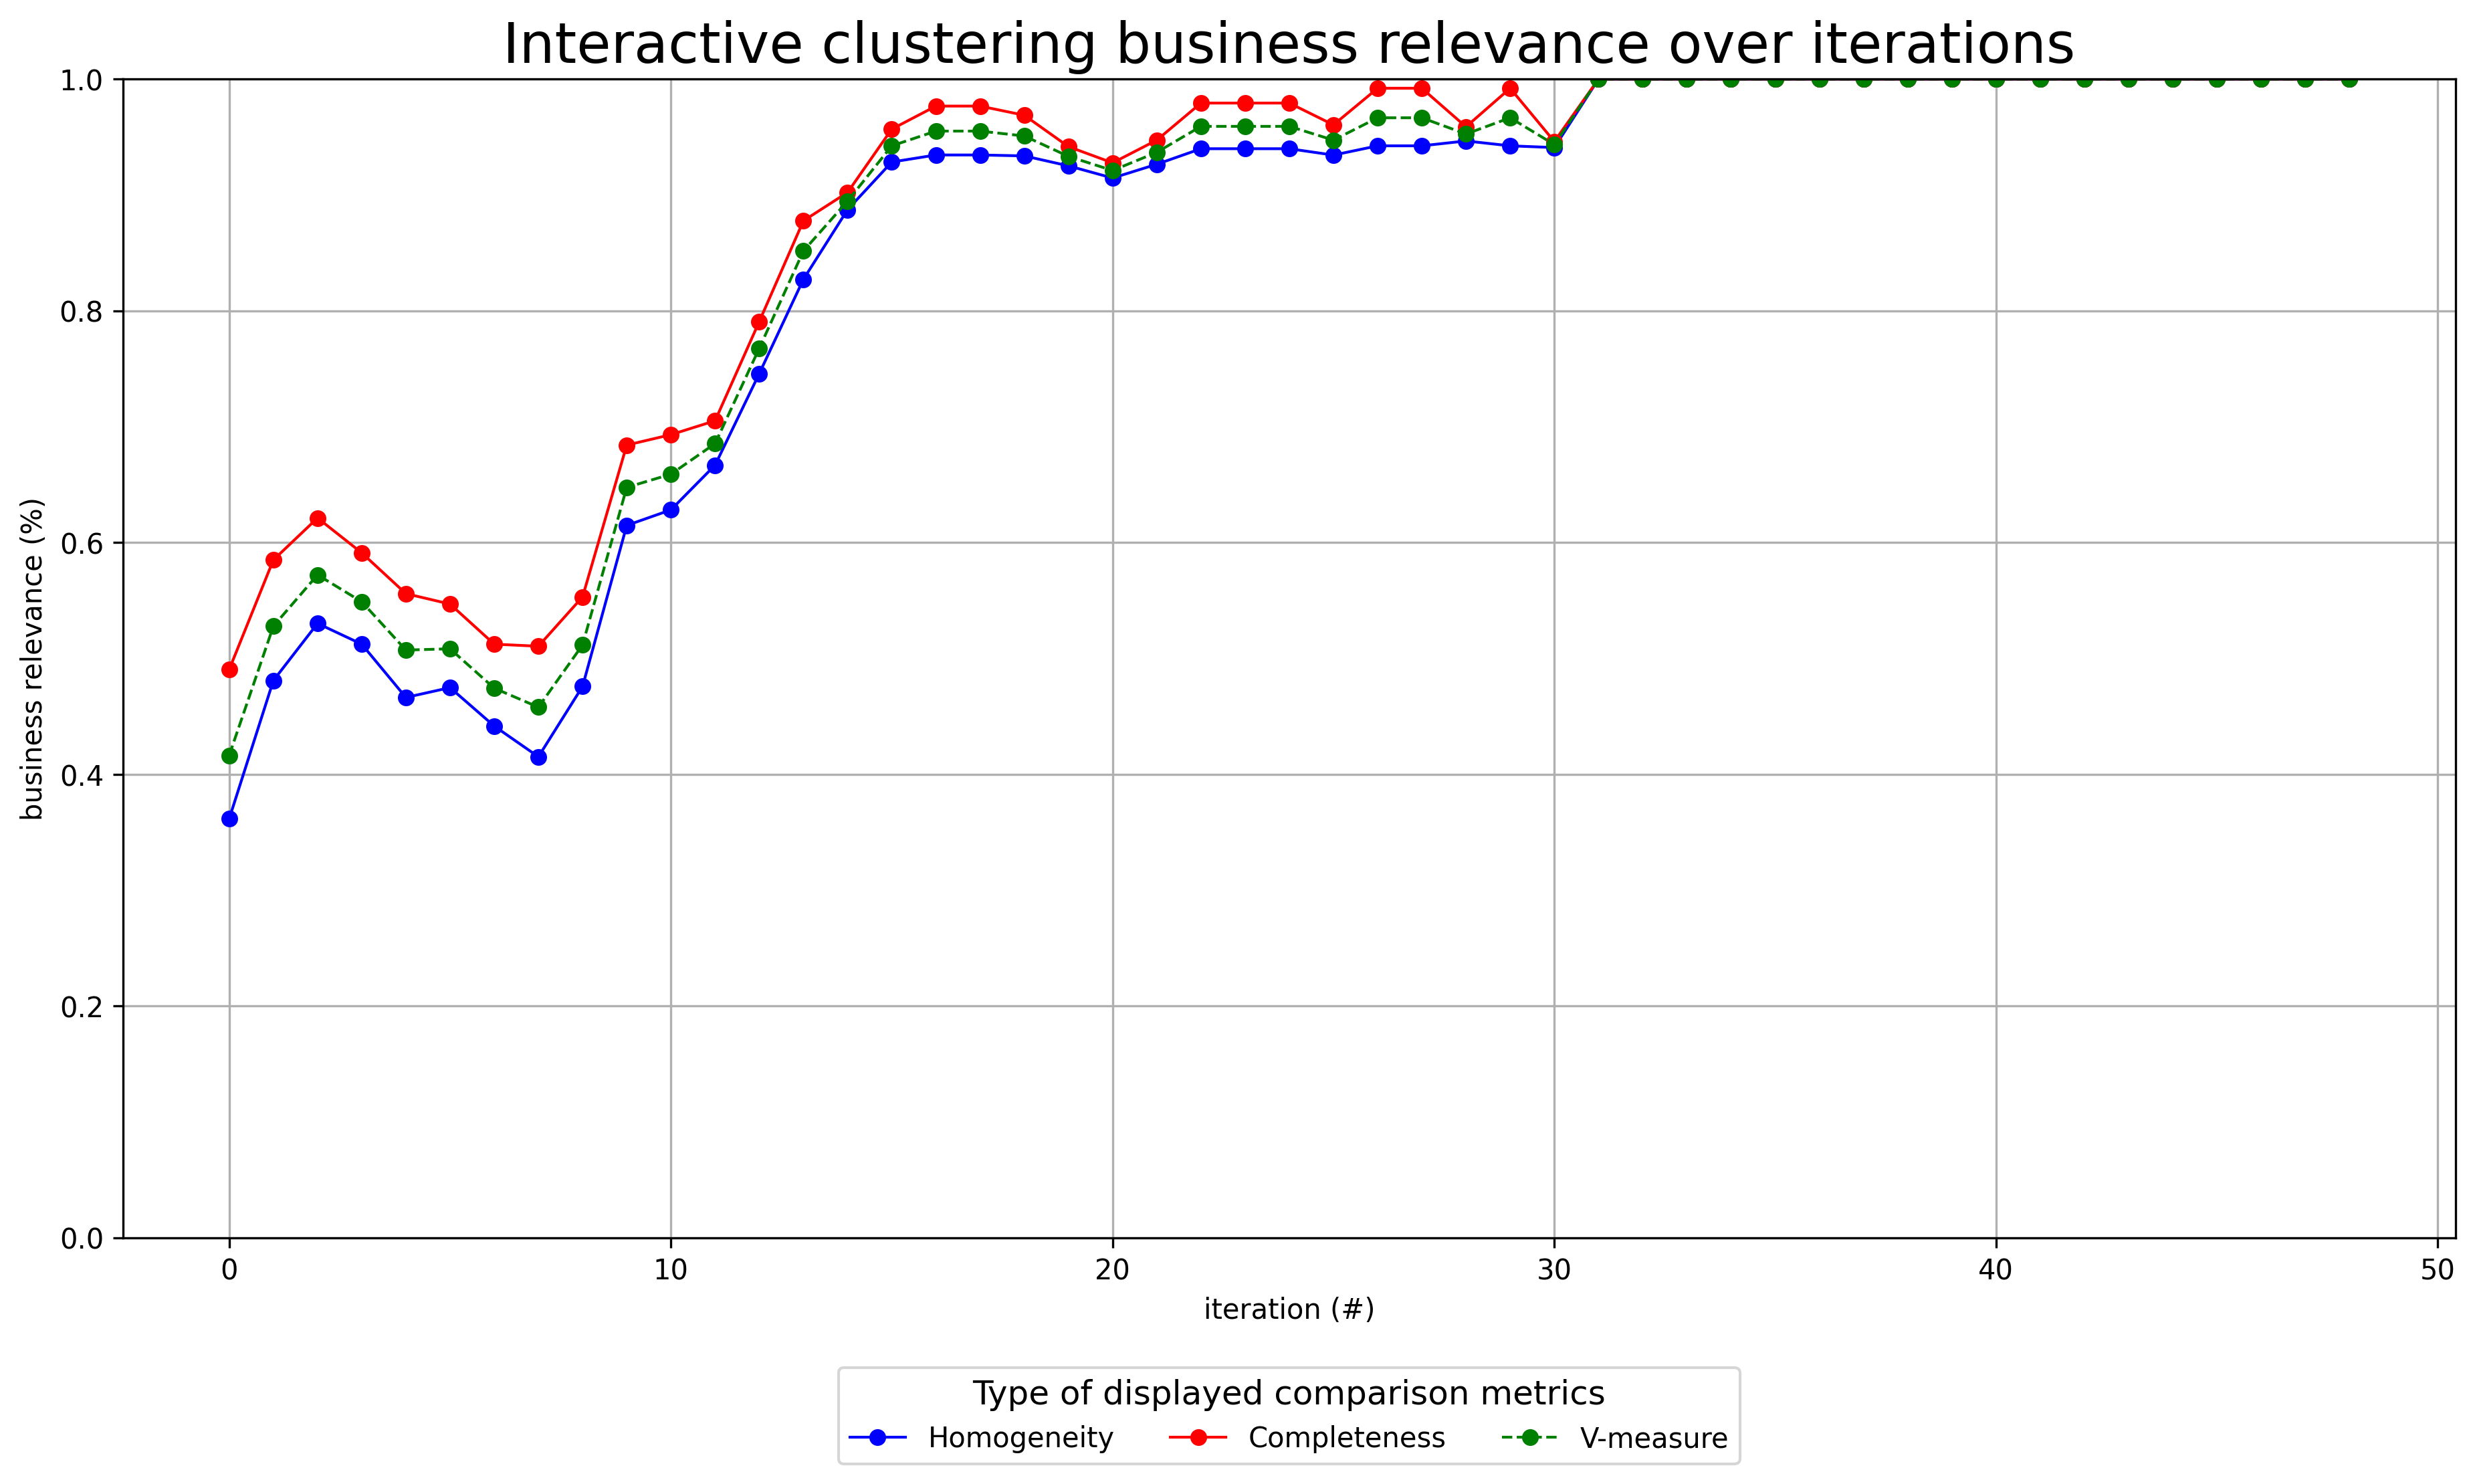

In [19]:
# Create a new figure.
fig: Figure = plt.figure(figsize=(15, 7.5), dpi=300.0)
axis = fig.gca()

# Define list of iterations to plot.
list_of_iteration: List[int] = [
    int(iteration) for iteration in comparison_score_evolution.keys()
]

# Set range of axis.
axis.set_ylim(ymin=0, ymax=1)

# Plot homogeneity evolution.
axis.plot(
    list_of_iteration,  # x
    [
        comparison_score_evolution[iteration][0]
        for iteration in comparison_score_evolution.keys()
    ],  # y
    label="Homogeneity",
    marker="o",
    markerfacecolor="blue",
    markersize=5,
    color="blue",
    linewidth=1,
)

# Plot completness evolution.
axis.plot(
    list_of_iteration,  # x
    [
        comparison_score_evolution[iteration][1]
        for iteration in comparison_score_evolution.keys()
    ],  # y
    label="Completeness",
    marker="o",
    markerfacecolor="red",
    markersize=5,
    color="red",
    linewidth=1,
)

# Plot v-measure evolution.
axis.plot(
    list_of_iteration,  # x
    [
        comparison_score_evolution[iteration][2]
        for iteration in comparison_score_evolution.keys()
    ],  # y
    label="V-measure",
    marker="o",
    markerfacecolor="green",
    markersize=5,
    color="green",
    linewidth=1,
    linestyle="dashed",
)

# Set axis name.
axis.set_xlabel("iteration (#)")
axis.set_ylabel("business relevance (%)")

# Plot the title.
axis.set_title("Interactive clustering business relevance over iterations", fontsize=20)

# Plot the legend.
axis.legend(
    bbox_to_anchor=(0.50, -0.10),
    title="Type of displayed comparison metrics",
    loc="upper center",
    ncol=4,
    title_fontsize=12,
    fontsize=10,
)

# Plot the grid.
axis.grid(True)

-----
## _DRAFT FMC ANALYSIS

In [14]:
fmc_computer_dataset.list_of_possible_classes

['alerte_perte_vol_carte',
 'carte_avalee',
 'commande_carte',
 'consultation_solde',
 'couverture_assurrance',
 'deblocage_carte',
 'gestion_carte_virtuelle',
 'gestion_decouvert',
 'gestion_plafond',
 'gestion_sans_contact']

In [15]:
fmc_computer_clustering.list_of_possible_classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [16]:
pd.DataFrame(fmc_computer_clustering.features_fmeasure)
# vouloir commander = 0.006 ; 0.009 ; 8*0

,2000,2000 euro,2000 euro paiement,achat,achat internet,achat ligne,achat numero,achat numero carte,actif,actif carte,...,voler carte,voler carte bleu,vouloir,vouloir activer,vouloir commander,vouloir connaitre,vouloir connaitre solde,vouloir signaler,vouloir signaler perte,voyage
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014514,0.014514,...,0.00000,0.000000,0.014504,0.014327,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.01144,0.006033,0.014826,0.000000,0.002543,0.002187,0.000000,0.00000,0.00000,0.000000
2,0.000000,0.000000,0.000000,0.047525,0.016783,0.010232,0.023316,0.016522,0.000000,0.000000,...,0.00000,0.000000,0.003750,0.000000,0.000000,0.005594,0.005886,0.00000,0.00000,0.000000
3,0.001939,0.001939,0.001939,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00351,0.000000,0.015802,0.000000,0.004335,0.000000,0.000000,0.00531,0.00531,0.000000
4,0.000000,0.000000,0.000000,0.015528,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.018232
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.011634,0.000000,0.000000,0.019174,0.020308,0.00000,0.00000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
7,0.000000,0.000000,0.000000,0.022630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.053183
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.013970,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
9,0.006721,0.006721,0.006721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.007742,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.016354


In [17]:
fmc_computer_clustering.features_marginal_averages
# vouloir commander = 0.0015 = 0.015/10 ou 0.0015/2 ?

{'2000': 0.0008659958816678772,
 '2000 euro': 0.0008659958816678772,
 '2000 euro paiement': 0.0008659958816678772,
 'achat': 0.008568315122848202,
 'achat internet': 0.0016782557090729803,
 'achat ligne': 0.0010231712276056518,
 'achat numero': 0.002331647006313152,
 'achat numero carte': 0.0016521537549619198,
 'actif': 0.0014514086182935019,
 'actif carte': 0.0014514086182935019,
 'activer': 0.008513345718830462,
 'activer carte': 0.0011310397043063736,
 'activer contact': 0.002710539897970878,
 'activer mode': 0.0012238612187442683,
 'activer numero': 0.0013226874565557272,
 'activer numero carte': 0.0013226874565557272,
 'activer option': 0.0033372854626623322,
 'activer possibilite': 0.0005818558312619356,
 'actuel': 0.002294689931672553,
 'aimer': 0.008925143347675222,
 'aimer utiliser': 0.0013609779976280205,
 'aller': 0.0006912437049188461,
 'annuler': 0.0029180181874581814,
 'application': 0.0076782765851634485,
 'argent': 0.019923921525303107,
 'argent compte': 0.012778530764

In [18]:
pd.DataFrame(fmc_computer_clustering.features_activation)

,2000,2000 euro,2000 euro paiement,achat,achat internet,achat ligne,achat numero,achat numero carte,actif,actif carte,...,voler carte,voler carte bleu,vouloir,vouloir activer,vouloir commander,vouloir connaitre,vouloir connaitre solde,vouloir signaler,vouloir signaler perte,voyage
0,False,False,False,False,False,False,False,False,True,True,...,False,False,True,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,True,True,True,False,True,False,False,False,False,False
2,False,False,False,True,True,True,True,True,False,False,...,False,False,False,False,False,True,True,False,False,False
3,True,True,True,False,False,False,False,False,False,False,...,True,False,True,False,True,False,False,True,True,False
4,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
5,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,True,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
8,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
9,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [19]:
pd.DataFrame(fmc_computer_clustering.features_contrast)

,2000,2000 euro,2000 euro paiement,achat,achat internet,achat ligne,achat numero,achat numero carte,actif,actif carte,...,voler carte,voler carte bleu,vouloir,vouloir activer,vouloir commander,vouloir connaitre,vouloir connaitre solde,vouloir signaler,vouloir signaler perte,voyage
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,10.0,10.0,...,0.000000,0.0,1.763930,10.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,7.652351,10.0,1.803073,0.0,3.697153,0.811498,0.000000,0.0,0.0,0.000000
2,0.000000,0.000000,0.000000,5.546634,10.0,10.0,10.0,10.0,0.0,0.0,...,0.000000,0.0,0.456014,0.0,0.000000,2.075376,2.247073,0.0,0.0,0.000000
3,2.238699,2.238699,2.238699,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,2.347649,0.0,1.921732,0.0,6.302847,0.000000,0.000000,10.0,10.0,0.000000
4,0.000000,0.000000,0.000000,1.812209,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,2.077245
5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,1.414839,0.0,0.000000,7.113126,7.752927,0.0,0.0,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
7,0.000000,0.000000,0.000000,2.641157,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,6.059420
8,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,1.698900,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
9,7.761301,7.761301,7.761301,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.941512,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.863335


-----
## _DRAFT FMC COMPARISON

$
H(C)
= - \sum _{c \subset C} P_{C}(c) \log P_{C}(c)
\\ = - \sum _{c \subset C} \frac{|c|}{N} \log \frac{|c|}{N}
$

where :
- $C=\{c\}$ = the labeling formated as a list of sets of data with the same label.
- $N$ = nb of data.

$
MI(C,K)
= \sum _{c \subset C} \sum _{k \subset K} P_{C,K}(c,k) log \frac{P_{C,K}(c,k)}{P_{C}(c) P_{K}(k)}
\\ = \sum _{c \subset C} \sum _{k \subset K} \frac{|c \cap k|}{N} \log \frac{ N |c \cap k|}{|c||k|}
$

where :
- $C=\{C_i\}$ = the reference labeling formated as a list of sets of data with the same label.
- $K=\{K_j\}$ = the clustering labeling formated as a list of sets of data with the same label.
- $N$ = nb of data.

$COMP(C,K) = \frac{MI(C,K)}{H(C)}$

$HOM(C,K) = \frac{MI(C,K)}{H(K)}$

$VM(C,K) = \frac{2*HOM*COMP}{HOM+COMP}$